# Convolutional Neural Networks - Age Prediction

## Preparations

In [66]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = "D:/Users/Julian/OneDrive - FH OOe/Kurse/3. Semester/NDLeIL/Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'age-prediction/20-50')

In [67]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import show_img_data, plot_history, evaluate_regression_result

In [68]:
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

## Configure Data Sources

In [69]:
batch_size = 64
img_size = (224, 224)

In [70]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='training',
    seed = 4232,
    image_size=img_size,
    batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='validation',
    seed=4232,
    image_size=img_size,
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size)

Found 33432 files belonging to 31 classes.
Using 28418 files for training.
Found 33432 files belonging to 31 classes.
Using 5014 files for validation.
Found 7008 files belonging to 31 classes.


In [71]:
train_data.class_names

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50']

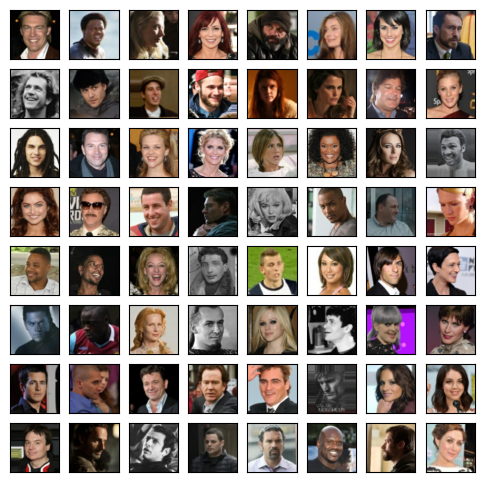

In [72]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch / 255., no=batch_size, layout=(8, 8), figsize=(6, 6))
    break

## Create Model
### Modified compared to model 3:
* Replace feature extraction with a pre-trained model (ResNet50)

In [73]:
# 1. Data augmentation
data_augmentation = tf.keras.models.Sequential([
   tf.keras.layers.RandomFlip('horizontal'),
   tf.keras.layers.RandomRotation(0.02, fill_mode='constant', fill_value=0.),
   tf.keras.layers.RandomZoom(0.1, fill_mode='constant', fill_value=0.)
], name='data_augmentation')

# 2. Functional API implementation
i = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 3))
x = data_augmentation(i)
x = tf.keras.applications.resnet50.preprocess_input(x)

# 3. ResNet50 backbone
core = tf.keras.applications.ResNet50(
   include_top=False,
   weights='imagenet',
   pooling='avg'
)
core.trainable = False
x = core(x)

# 4. Classification head
x = tf.keras.layers.Dense(256, activation=None)(x)  # 2048 -> 256
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation=None)(x)   # 256 -> 64
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
o = tf.keras.layers.Dense(1, activation=None)(x)    # 64 -> 1

# 5. Model compilation & callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
   monitor='val_mae',
   factor=0.5,
   patience=3,
   min_lr=1e-6,
   verbose=1
)

model = tf.keras.Model(inputs=i, outputs=o)
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
   loss='mse',
   metrics=['mae']
)

In [74]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_18[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_21         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_22         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_23         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_7 (Stack)     │ (None, 224, 224,  │          0 │ get_item_21[0][0… │
│                     │ 3)                │            │ get_item_22[0][0… │
│                     │                   │            │ get_item_23[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 224, 224,  │          0 │ stack_7[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add_7[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    524,544 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ activation_14[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │     16,448 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ activation_15[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         65 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 24,130,049 (92.05 MB)

 Trainable params: 541,697 (2.07 MB)

 Non-trainable params: 23,588,352 (89.98 MB)

## Train Model

In [75]:
filepath = os.path.join(base_dir, 'Models/age-prediction_model4/age-prediction4_{epoch:02d}-{val_mae:.4f}.keras')

# Callbacks for saving the best models
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_data, epochs=50, validation_data=validation_data,
                    callbacks=callbacks_list)

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 280.4810 - mae: 14.3449
Epoch 1: val_mae improved from inf to 13.57220, saving model to ../../Models/age-prediction_model4/age-prediction4_01-13.5722.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 1519s 3s/step - loss: 280.4509 - mae: 14.3441 - val_loss: 249.7526 - val_mae: 13.5722 - learning_rate: 1.0000e-04
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 232.1818 - mae: 12.9042
Epoch 2: val_mae improved from 13.57220 to 12.39537, saving model to ../../Models/age-prediction_model4/age-prediction4_02-12.3954.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 1451s 3s/step - loss: 232.1575 - mae: 12.9034 - val_loss: 215.0108 - val_mae: 12.3954 - learning_rate: 1.0000e-04
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 192.3990 - mae: 11.5257
Epoch 3: val_mae improved from 12.39537 to 11.04027, saving model to ../../Models/age-prediction_model4/age-prediction4_03-11.0403.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 1449s 3s/step - loss: 192.3768

KeyboardInterrupt: 

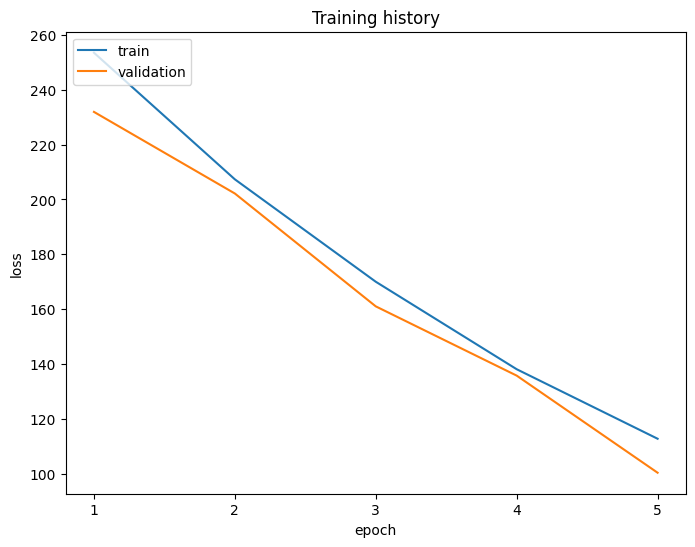

In [76]:
plot_history(history)

## Evaluate on Test Data

In [ ]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step


In [ ]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

In [ ]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset

Target feature 0:
    Mean squared error (MSE):          100.208
    Root mean squared error (RMSE):     10.010
    Mean absolute error (MAE):           8.129
    Coefficient of determination (R2):  -0.237
    Correlation coefficient (Pearson):   0.434 (p = 2.16e-319)


## Evaluate on Test Data (best model)

In [77]:
# Load the best model
model = tf.keras.models.load_model(r"../../Models\age-prediction_model4\age-prediction4_14-6.4174.keras")

In [78]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step


In [79]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset 

Target feature 0:
    Mean squared error (MSE):           62.448
    Root mean squared error (RMSE):      7.902
    Mean absolute error (MAE):           6.507
    Coefficient of determination (R2):   0.229
    Correlation coefficient (Pearson):   0.483 (p = 0.00e+00)


In [80]:
!jupyter nbconvert --to html Ex4_Grimm_Model4.ipynb

[NbConvertApp] Converting notebook Ex4_Grimm_Model4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 854343 bytes to Ex4_Grimm_Model4.html
